In [32]:
import sys
sys.path.append('../lib')
import json
import pandas as pd
import matplotlib.pyplot as plt
from random_eraser import get_random_eraser
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import cv2
import json
# import symspellpy.editdistance 
from PIL import Image

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

In [33]:
labels = json.load(open('../labels/labels.json'))

In [34]:
y = pd.DataFrame(list(labels.values()), columns=['y'])

In [35]:
y['length'] = y['y'].str.len()
y['comma'] = y['y'].str.split(',').str.len()

In [36]:
y.head()

,y,length,comma
0,"Số 253 đường Trần Phú, Thị trấn Nam Sách, Huyệ...",67,4
1,"Số 289 Đinh Bộ Lĩnh, Phường 26, Quận Bình Thạn...",63,4
2,"Số 246E/2, Khu phố 1B, Phường An Phú, Tx Thuận...",61,5
3,"42 Đặng Thị Nhu, Phường Nguyễn Thái Bình, Quận...",64,4
4,"200 Phan Bội Châu, Phường Trường An, Thành phố...",68,4


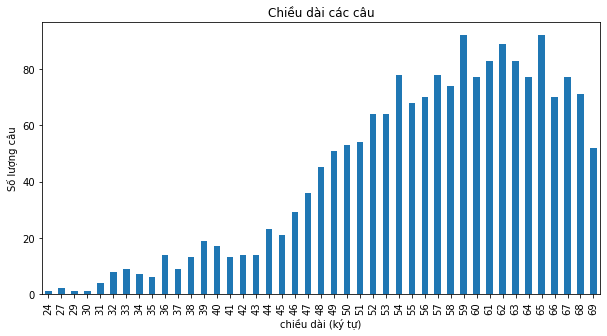

In [37]:
y['length'].value_counts().sort_index().plot.bar()
plt.title("Chiều dài các câu")
plt.ylabel("Số lượng câu")
plt.xlabel("chiều dài (ký tự)");

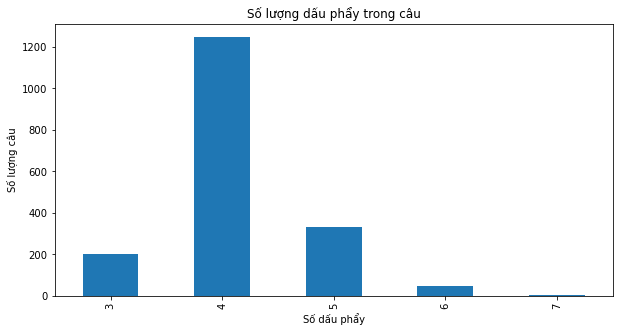

In [38]:
y['comma'].value_counts().sort_index().plot.bar()
plt.title("Số lượng dấu phẩy trong câu")
plt.ylabel("Số lượng câu")
plt.xlabel("Số dấu phẩy");

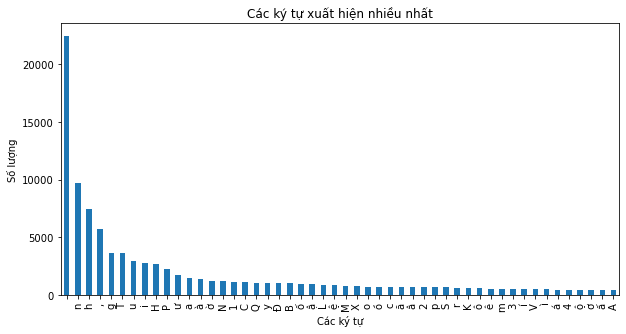

In [39]:
pd.value_counts(list(' '.join(y['y'].values))).head(50).plot.bar()
plt.title("Các ký tự xuất hiện nhiều nhất")
plt.ylabel("Số lượng")
plt.xlabel("Các ký tự");

Từ Điển các ký tự có trong tiếng Việt

In [40]:
''.join(sorted(list(set(list(' '.join(y['y'].values))))))

" #'()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstuvxyzÂÊÔàáâãèéêìíòóôõùúýăĐđĩũƠơưạảấầẩậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ"

In [41]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [42]:
random_eraser = get_random_eraser(p=1, s_l=0.004, s_h=0.005, r_1=0.01, r_2=1/0.01, v_l=0, v_h=1)

Tự tạo thêm câu

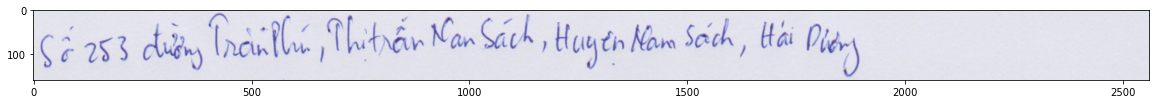

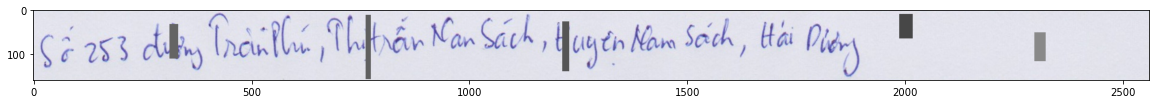

In [43]:
plt.figure(figsize=(20, 10))
img = image.load_img('../data/0000_samples.png', target_size=(160, 2560), interpolation='bicubic')
img = image.img_to_array(img)/255
plt.imshow(img)

img_eraser = random_eraser(img)
for _ in range(4):
    img_eraser = random_eraser(img_eraser)


plt.figure(figsize=(20, 10))
plt.imshow(img_eraser)

In [44]:
image_datagen_args = {
                'shear_range': 0.1,
                'zoom_range': 0.01,
                'width_shift_range': 0.001,
                'height_shift_range': 0.1,
                'rotation_range': 1,
                'horizontal_flip': False,
                'vertical_flip': False
        }
image_datagen = ImageDataGenerator(**image_datagen_args)

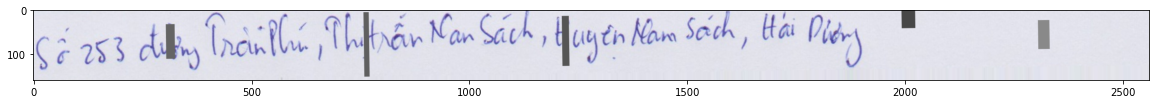

In [45]:
params = image_datagen.get_random_transform(img.shape)
img_aug = image_datagen.apply_transform(img, params)
plt.figure(figsize=(20, 10))
plt.imshow(img_aug)

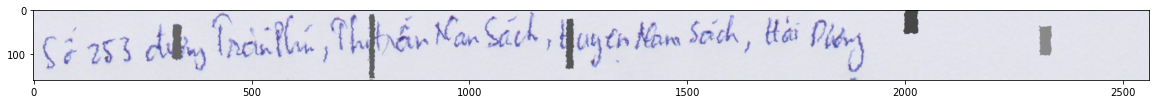

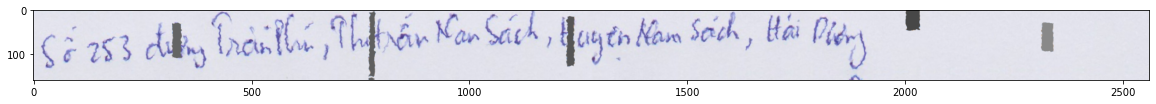

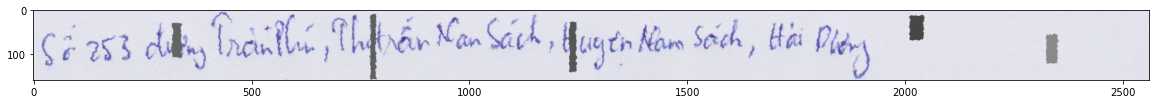

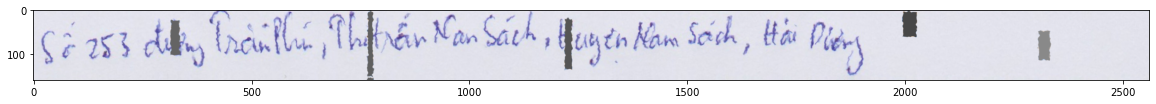

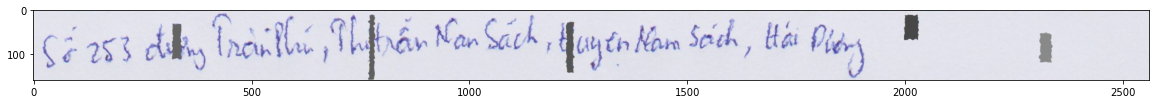

In [46]:
for _ in range(5):
    plt.figure(figsize=(20, 10))
    elastic_img = elastic_transform(img, 20, 2,0.7)
    plt.imshow(elastic_img)

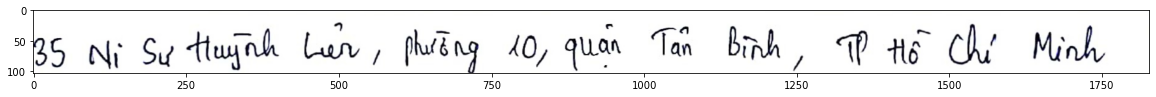

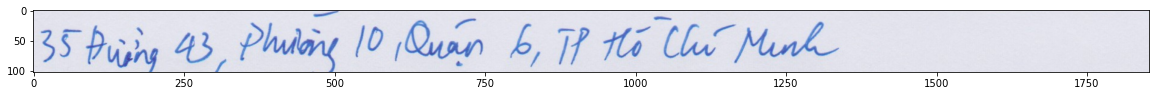

In [47]:
plt.figure(figsize=(20, 10))
img = image.load_img('../test/0006_tests.png')
img = image.img_to_array(img)/255
plt.imshow(img)
plt.figure(figsize=(20, 10))
img = image.load_img('../data/1814_samples.png')
img = image.img_to_array(img)/255
plt.imshow(img)

In [57]:
test_labels = json.load(open('../labels/labels_test.json'))
predict = json.load(open('../predict/predict.json'))

In [51]:
import editdistance

In [52]:
test1 = 'Số 10, đường Lý Văn Lâm, Phường 1, Thành Phố Cà Mau, Cà Mau'
test2 = 'Số 0, đường L Văn Lm, Phường 1, Thành Phố C Mau, Cà Mau'

In [53]:
editdistance.eval(test1, test2)

4

In [68]:
def loss_score(y_predict, y_label):
    score_list = []
    length_y = len(y_label)
    for key, value in y_label.items():                  
        score_list.append(editdistance.eval(y_predict[key] ,value)/len(value))
    return sum(score_list)/length_y

In [69]:
loss_score(predict, test_labels)

0.11177799499851875